Muhammad Mustafa 25850354
Zunaira Zunaira  10931968
Zalfa Mohayyudin 12749927

# Problem Sheet 03

> Muhammad Mustafa 25850354

> Zunaira Zunaira  10931968

>Zalfa Mohayyudin 12749927

In [ ]:
# import libarires
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from scipy.interpolate import griddata
import os

## **Exercise 1.1**

In [2]:
# 1. Convert Station File to CSV and Plot

# Load station info
stations = []
with open("zehn_min_rr_Beschreibung_Stationen.txt", 'r', encoding='latin1') as file:
    for line in file:
        parts = line.strip().split()
        if len(parts) >= 6 and parts[0].isdigit():
            stations.append(parts[:6])

# Create DataFrame
stations_df = pd.DataFrame(stations, columns=["Stations_id", "Von_datum", "Bis_datum", "Stationshoehe", "geoBreite", "geoLaenge"])
stations_df = stations_df.astype({
    "Stations_id": int,
    "Stationshoehe": float,
    "geoBreite": float,
    "geoLaenge": float
})

In [11]:
stations_df

,Stations_id,Von_datum,Bis_datum,Stationshoehe,geoBreite,geoLaenge
0,20,20040812,20240422,432.0,48.9219,9.9129
1,44,20070208,20240422,44.0,52.9336,8.2370
2,53,20050831,20240422,60.0,52.5850,13.5634
3,73,20070213,20240422,374.0,48.6183,13.0620
4,78,20041010,20240422,64.0,52.4853,7.9125
...,...,...,...,...,...,...
1063,19172,20200820,20240422,48.0,54.0246,9.3880
1064,19207,20230330,20240422,16.0,53.8178,12.0645
1065,19299,20210322,20240422,463.0,49.8713,11.7883
1066,19897,20231231,20240422,37.0,52.5040,13.4550


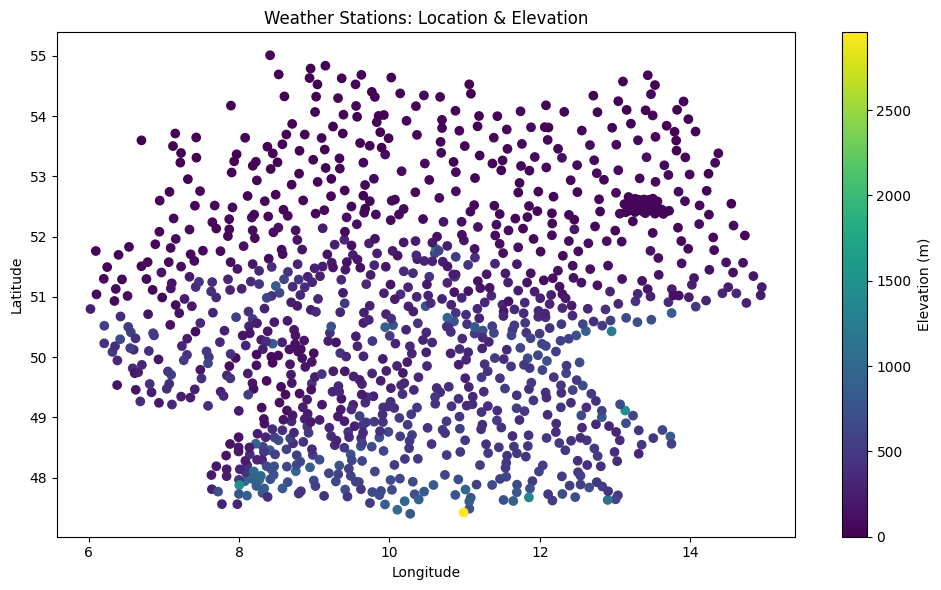

In [3]:
# Scatter plot of stations
plt.figure(figsize=(10, 6))
scatter = plt.scatter(stations_df["geoLaenge"], stations_df["geoBreite"],
                       c=stations_df["Stationshoehe"], cmap="viridis")
plt.colorbar(scatter, label="Elevation (m)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Weather Stations: Location & Elevation")
plt.tight_layout()
plt.savefig("stations_scatter.png")
plt.show()

In [21]:
# Load precipitation data
precip_df = pd.read_csv("10min_processed.csv")

#data preprocess
precip_df["date"]=pd.to_datetime(precip_df["date"], format="%Y%m%d%H%M")
precip_df["hour"]=precip_df["date"].dt.floor("H")
precip_df["hour"]=pd.to_datetime(precip_df["hour"])
precip_df["rain"]=precip_df["rain"].replace(-999,0)

C:\Users\Mustafa\AppData\Local\Temp\ipykernel_11996\3803702192.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  precip_df["hour"]=precip_df["date"].dt.floor("H")


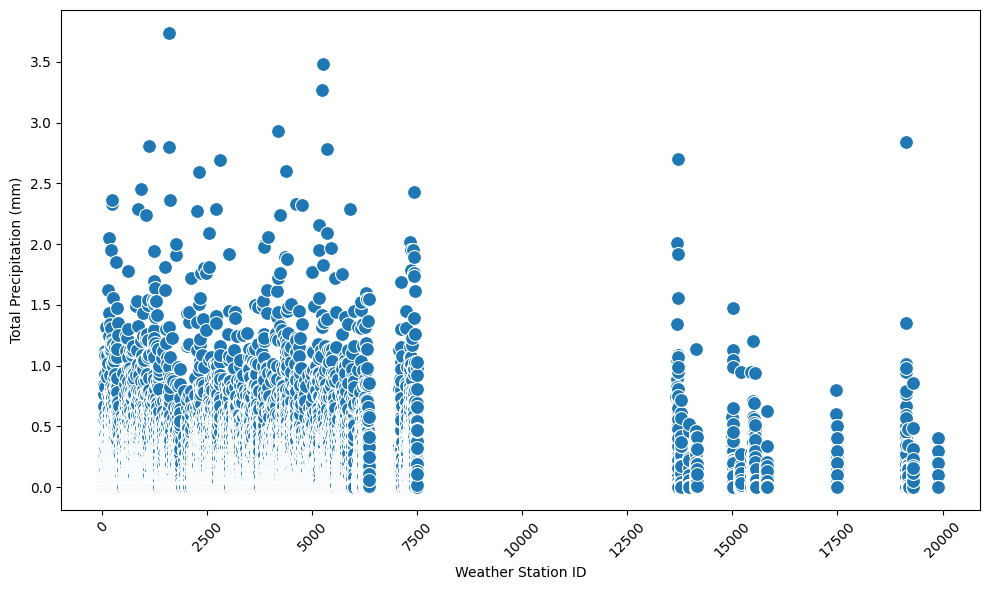

In [23]:

# Group by station and hour
agg_precip = precip_df.groupby(["stationid", "date", "hour"])["rain"].sum().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=agg_precip, x="stationid", y="rain", s=100)
#plt.title(f"Total Precipitation per Station at {target_hour}:00 on {target_date}")
plt.xlabel("Weather Station ID")
plt.ylabel("Total Precipitation (mm)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


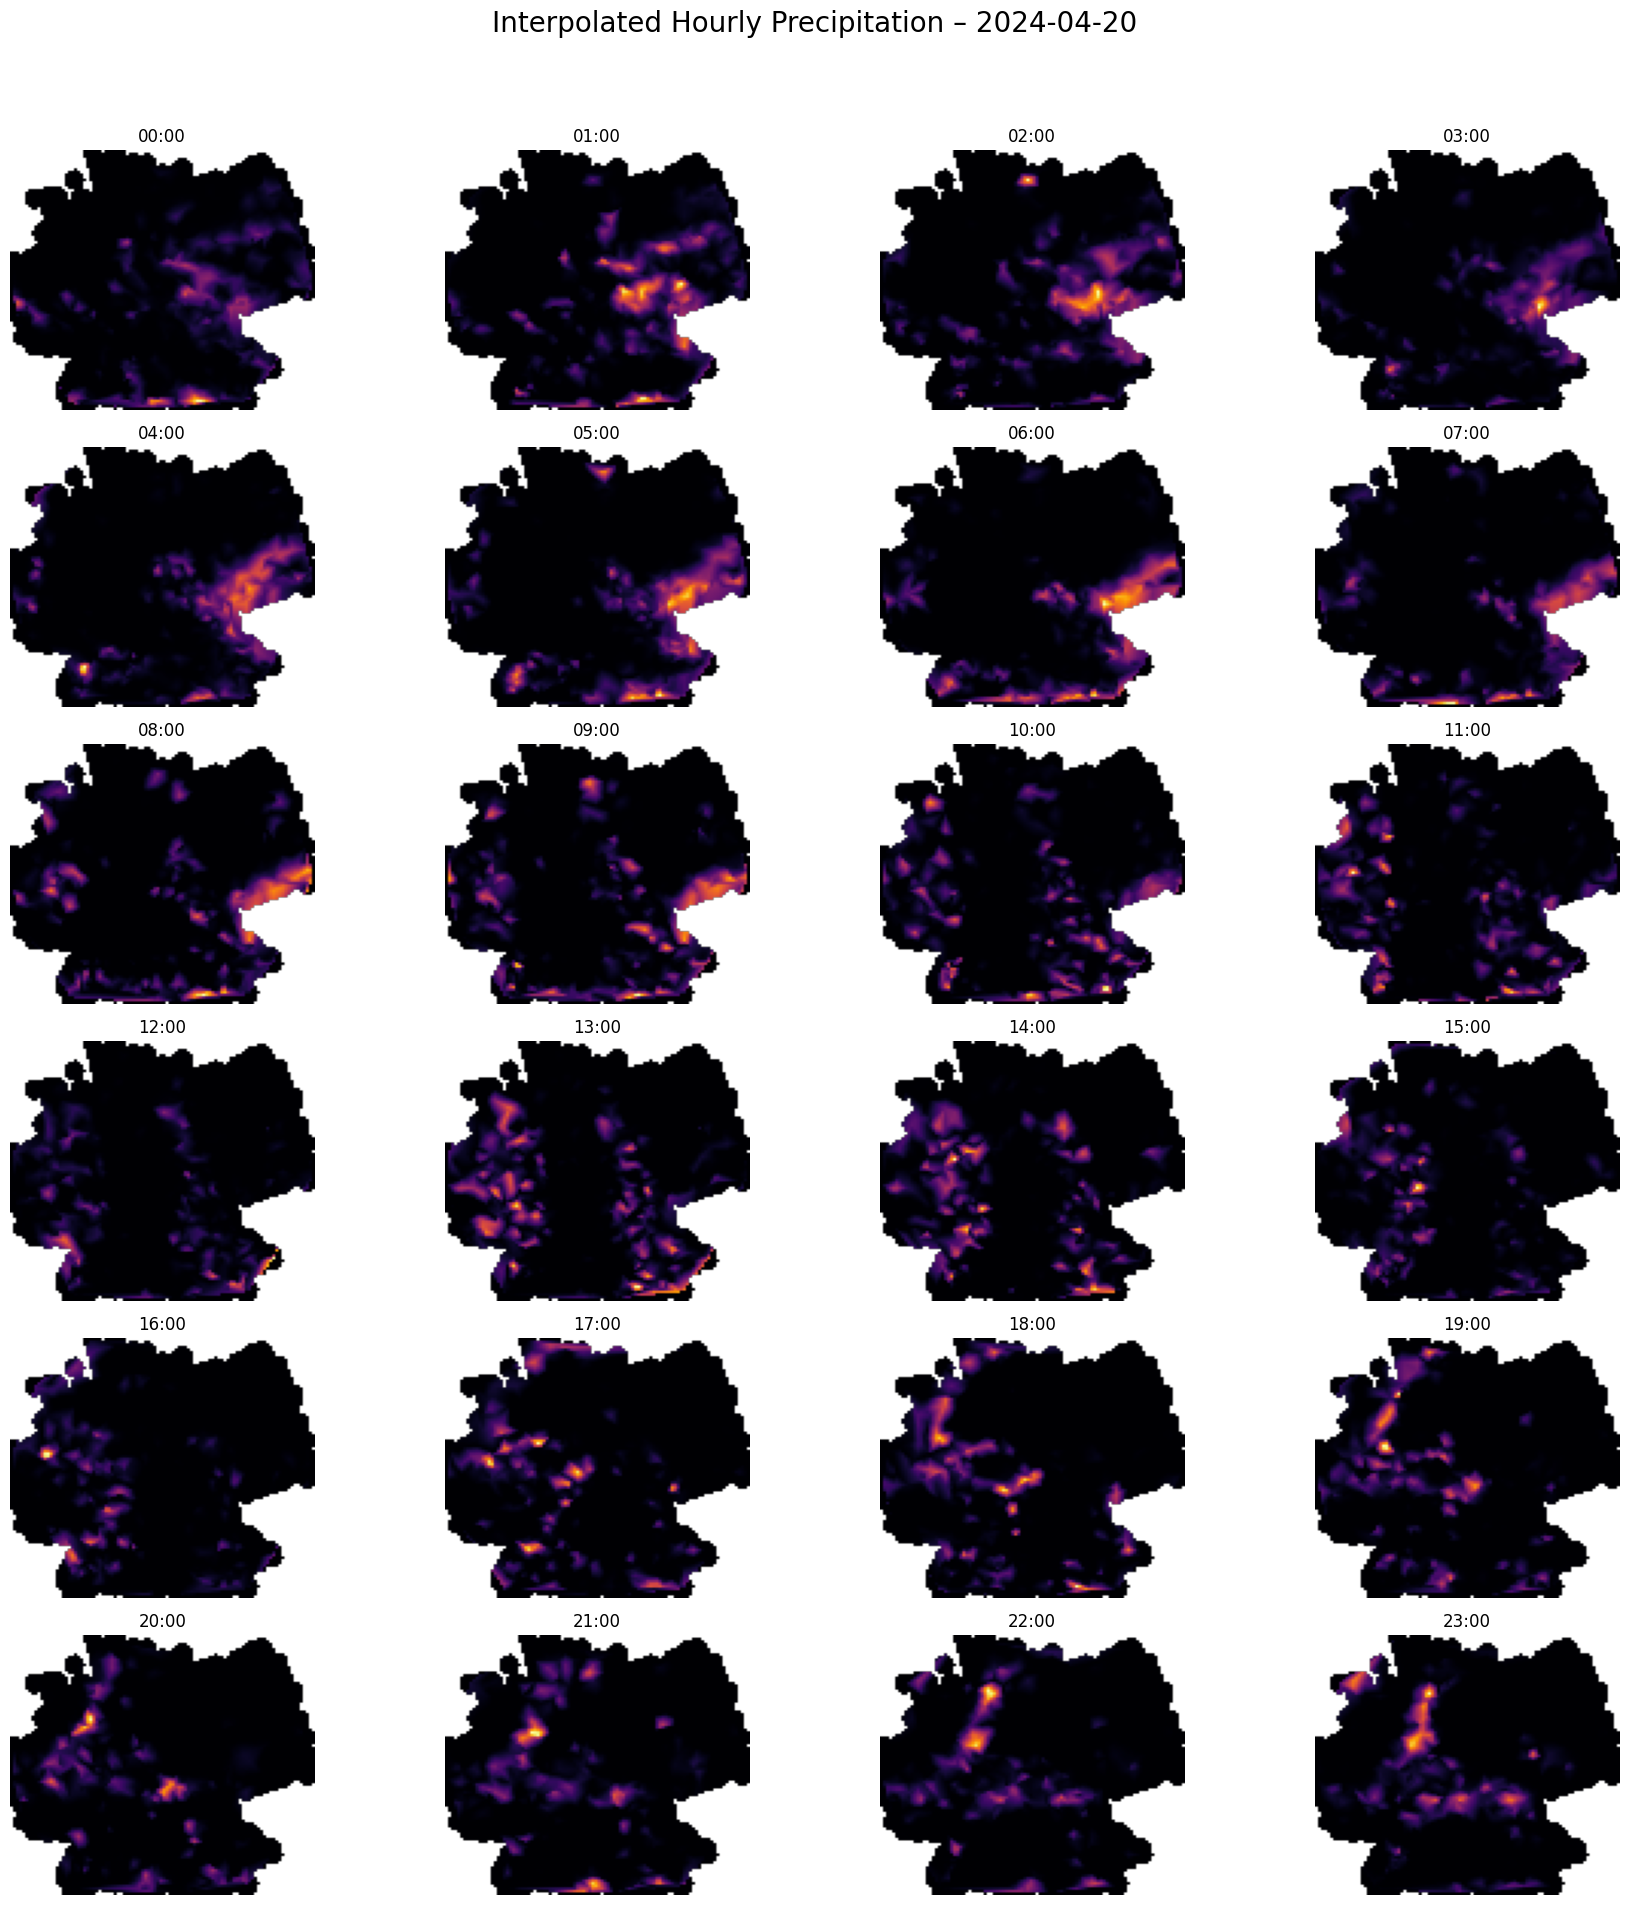

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Load the grid
data = np.load("griddata.npz")
geolat = data["geolat"]     # 2D latitude grid
geolong = data["geolong"]   # 2D longitude grid
ind = data["ind"]           # 2D boolean mask of valid area

# Preprocess precipitation data
hourly_precip = precip_df.groupby(["stationid", "hour"])["rain"].sum().reset_index()

# Setup figure for 24 hours
fig, axes = plt.subplots(6, 4, figsize=(18, 20))  # 6 rows × 4 columns = 24 plots
axes = axes.flatten()

# Loop over each hour
for idx, hour in enumerate(pd.date_range("2024-04-20 00:00", "2024-04-20 23:00", freq="h")):
    ax = axes[idx]
    
    # Subset data for this hour
    subset = hourly_precip[hourly_precip["hour"] == hour]
    if subset.empty:
        ax.set_title(hour.strftime("%H:%M") + " (No Data)")
        ax.axis("off")
        continue
    
    # Merge with station location info
    subset = subset.merge(stations_df, left_on="stationid", right_on="Stations_id")
    
    # Interpolation input
    points = subset[["geoLaenge", "geoBreite"]].values  # long, lat
    values = subset["rain"].values
    
    # Interpolate to grid
    grid_z = griddata(points, values, (geolong, geolat), method="linear", fill_value=0)
    
    # Apply region mask
    grid_z[~ind] = np.nan
    
    # Plot
    im = ax.imshow(grid_z, origin="lower", extent=[
        geolong.min(), geolong.max(), geolat.min(), geolat.max()
    ], cmap="inferno")
    
    ax.set_title(hour.strftime("%H:%M"))
    ax.axis("off")

# Global figure title and layout
fig.suptitle("Interpolated Hourly Precipitation – 2024-04-20", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust for suptitle
plt.show()


## **Exercise 1.2**

In [33]:
# make and array
points = np.array([
    [0, 0, 0],  [0, 1, 0],  [0, 1, 1], [0, 0, 1], 
    [1, 0, 0],  [1, 1, 0], [1, 1, 1], [1, 0, 1] ], dtype=np.double)


In [34]:
triangles = np.array([
    # Bottom face (z = 0): 0-1-5-4
    [0, 1, 5],
    [0, 5, 4],
    
    # Top face (z = 1): 3-2-6-7
    [3, 2, 6],
    [3, 6, 7],
    
    # Left face (x = 0): 0-3-2-1
    [0, 3, 2],
    [0, 2, 1],
    
    # Right face (x = 1): 4-5-6-7
    [4, 5, 6],
    [4, 6, 7],
    
    # Front face (y = 0): 0-4-7-3
    [0, 4, 7],
    [0, 7, 3],
    
    # Back face (y = 1): 1-2-6-5
    [1, 2, 6],
    [1, 6, 5]
], dtype=np.int32)


In [35]:
import plotly.graph_objects as go

# Get x, y, z coordinates
x, y, z = points[:,0], points[:,1], points[:,2]

# Create mesh plot
fig = go.Figure(data=[
    go.Mesh3d(
        x=x, y=y, z=z,
        i=triangles[:, 0],
        j=triangles[:, 1],
        k=triangles[:, 2],
        color='lightblue',
        opacity=0.5
    )
])

fig.update_layout(
    title='Triangulated Surface of Unit Cube',
    scene=dict(aspectmode='data')
)
fig.show()


In [36]:
# Step 1: Create a polar grid
n_radial = 20    # radial divisions
n_angular = 40   # angular divisions

r = np.linspace(0, 1, n_radial)
theta = np.linspace(0, 2 * np.pi, n_angular, endpoint=False)

r_grid, theta_grid = np.meshgrid(r, theta, indexing='ij')

# Step 2: Convert polar to Cartesian
x = (r_grid * np.cos(theta_grid)).flatten()
y = (r_grid * np.sin(theta_grid)).flatten()
z = np.zeros_like(x)

# Step 3: Build triangle indices
triangles = []
for i in range(n_radial - 1):
    for j in range(n_angular):
        # wrap around angularly
        j_next = (j + 1) % n_angular

        p0 = i * n_angular + j
        p1 = (i + 1) * n_angular + j
        p2 = (i + 1) * n_angular + j_next
        p3 = i * n_angular + j_next

        # two triangles per grid cell
        triangles.append([p0, p1, p2])
        triangles.append([p0, p2, p3])

triangles = np.array(triangles)

# Step 4: Visualize with Plotly
fig = go.Figure(data=[
    go.Mesh3d(
        x=x, y=y, z=z,
        i=triangles[:, 0],
        j=triangles[:, 1],
        k=triangles[:, 2],
        color='blue',
        opacity=0.7
    )
])

fig.update_layout(
    title="Triangular Mesh Approximation of the Unit Disk",
    scene=dict(aspectmode='data')
)

fig.show()


In [ ]:
# Step 1: Create a cylindrical grid
n_height = 20     # vertical divisions
n_angle = 50      # angular divisions

z_vals = np.linspace(0, 1, n_height)
theta_vals = np.linspace(0, 2 * np.pi, n_angle, endpoint=False)

z_grid, theta_grid = np.meshgrid(z_vals, theta_vals, indexing='ij')

# Step 2: Convert to Cartesian coordinates
x = np.cos(theta_grid).flatten()
y = np.sin(theta_grid).flatten()
z = z_grid.flatten()

# Step 3: Define triangle indices
triangles = []
for i in range(n_height - 1):
    for j in range(n_angle):
        j_next = (j + 1) % n_angle  # wrap around

        p0 = i * n_angle + j
        p1 = (i + 1) * n_angle + j
        p2 = (i + 1) * n_angle + j_next
        p3 = i * n_angle + j_next

        # two triangles per rectangular face
        triangles.append([p0, p1, p2])
        triangles.append([p0, p2, p3])

triangles = np.array(triangles)

# Step 4: Visualize with Plotly
fig = go.Figure(data=[
    go.Mesh3d(x=x, y=y, z=z,
        i=triangles[:, 0],
        j=triangles[:, 1],
        k=triangles[:, 2],
        color='green',
        opacity=0.7
    )
])

fig.update_layout(
    title="Triangular Mesh of the Cylinder Surface",
    scene=dict(aspectmode='data')
)

fig.show()
